# Master

#### Dependencies

In [237]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import scipy.sparse
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

import eli5

import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 1

from models.EDA import create_ydf
%aimport models.EDA
from models.models import evaluate_model
from models.plot import plot_confusion_matrix, plot_LSA, plot_correct_per_publisher
%aimport models.plot

from models.pipeline import make_features_pipeline, NumberSelector

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [2]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
cols = ['article_text', 'preprocessed_text', 'hyperpartisan', 'domain', 'bias', 'HP_links_count', 'nonHP_links_count', 'url']
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv', usecols=cols)
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv', usecols=cols)

#### Data Summary Statistics

In [3]:
train.shape[0]

580929

In [4]:
val.shape[0]

150000

In [5]:
val.duplicated(['url']).sum()

5268

In [6]:
len(train['domain'].value_counts())

158

In [7]:
len(val['domain'].value_counts())

83

In [8]:
train['bias'].value_counts(normalize=True)

least           0.303791
left            0.251657
right           0.250316
left-center     0.120583
right-center    0.073653
Name: bias, dtype: float64

In [9]:
val['bias'].value_counts(normalize=True)

least           0.255307
right           0.250000
left            0.250000
left-center     0.156487
right-center    0.088207
Name: bias, dtype: float64

#### Simple TF-IDF Logistic Regression Baseline

In [10]:
vec = TfidfVectorizer(min_df=3)

In [11]:
X_train_tfidf = vec.fit_transform(train['preprocessed_text'])
X_test_tfidf = vec.transform(val['preprocessed_text'])

In [12]:
y_train = train['hyperpartisan'].tolist()
y_test = val['hyperpartisan'].tolist()

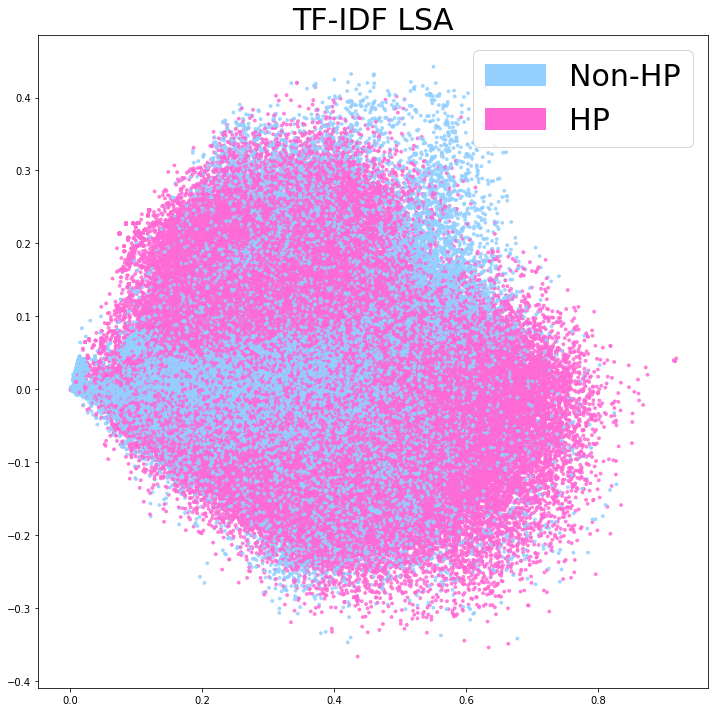

In [13]:
_ = plot_LSA(X_train_tfidf, y_train, title='TF-IDF LSA', save_path='../plots/lsa-tfidf')

In [55]:
lr = LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)
lr.fit(X_train_tfidf, y_train)
predicted = lr.predict(X_test_tfidf)

In [56]:
evaluate_model(y_test, predicted)

              precision    recall  f1-score   support

       False       0.68      0.38      0.49     75000
        True       0.57      0.82      0.67     75000

   micro avg       0.60      0.60      0.60    150000
   macro avg       0.63      0.60      0.58    150000
weighted avg       0.63      0.60      0.58    150000

Accuracy: 0.6033


0.6033266666666667

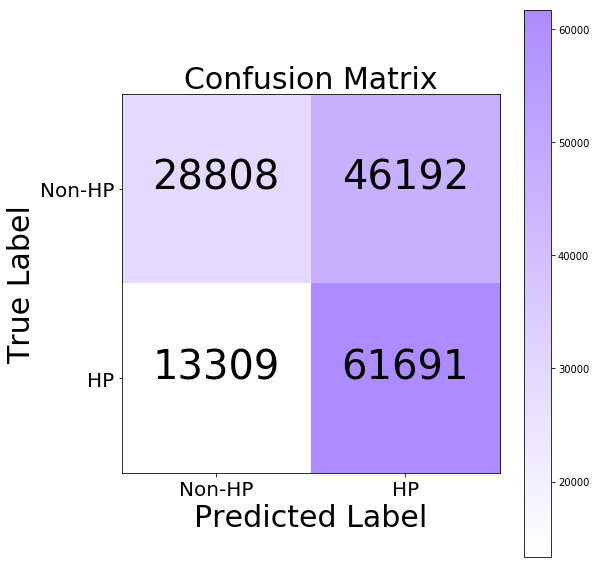

In [59]:
plot_confusion_matrix(y_test, predicted, save_path='../plots/confusion-lr-tfidf')

In [178]:
ydf = create_ydf(val, predicted)
ydf.to_csv(DATA_PROCESSED_PATH + 'ydf_for_pres.csv')

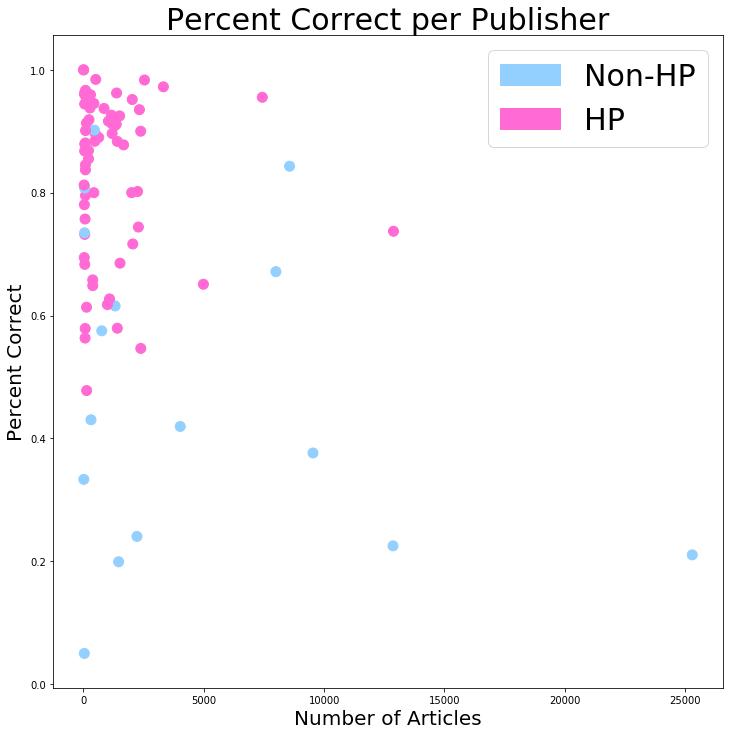

In [177]:
%matplotlib tk
plot_correct_per_publisher(ydf, save_path='../plots/pctcorrect-lr-tfidf')

In [19]:
eli5.explain_weights(lr, vec=vec)

Weight?,Feature
+17.535,marketwatch
+13.895,ka
+11.666,fool
+11.630,motley
+11.119,cital
+10.983,weons
+10.628,wire
+10.263,mr
+9.841,ht
+9.840,truthdig


In [111]:
sgd = SGDClassifier(tol=1e-3, max_iter=1000, penalty='l1', random_state=1)
sgd.fit(X_train_tfidf, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [112]:
predictions = sgd.predict(X_test_tfidf)
evaluate_model(y_test, predictions)

              precision    recall  f1-score   support

       False       0.63      0.32      0.43     75000
        True       0.55      0.81      0.65     75000

   micro avg       0.57      0.57      0.57    150000
   macro avg       0.59      0.57      0.54    150000
weighted avg       0.59      0.57      0.54    150000

Accuracy: 0.5677


0.5677466666666666

In [113]:
rf = RandomForestClassifier(n_jobs=-1, verbose=1, n_estimators=100, class_weight='balanced', max_features=15, random_state=1)
rf.fit(X_train_tfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.7min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=15,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=1, warm_start=False)

In [114]:
predictions = rf.predict(X_test_tfidf)
evaluate_model(y_test, predictions)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.1s finished


              precision    recall  f1-score   support

       False       0.61      0.36      0.45     75000
        True       0.55      0.77      0.64     75000

   micro avg       0.57      0.57      0.57    150000
   macro avg       0.58      0.57      0.55    150000
weighted avg       0.58      0.57      0.55    150000

Accuracy: 0.5652


0.5651666666666667

#### Document Vectors

In [20]:
DATA_PROCESSED_PATH = DATA_PATH + 'processed/'

with open(DATA_PROCESSED_PATH + "inferred_doc_vectors_train.txt", "rb") as internal_filename:
    X_train_docvecs = np.array(list(pickle.load(internal_filename)))
    
with open(DATA_PROCESSED_PATH + "inferred_doc_vectors_test.txt", "rb") as internal_filename:
    X_test_docvecs = np.array(list(pickle.load(internal_filename)))

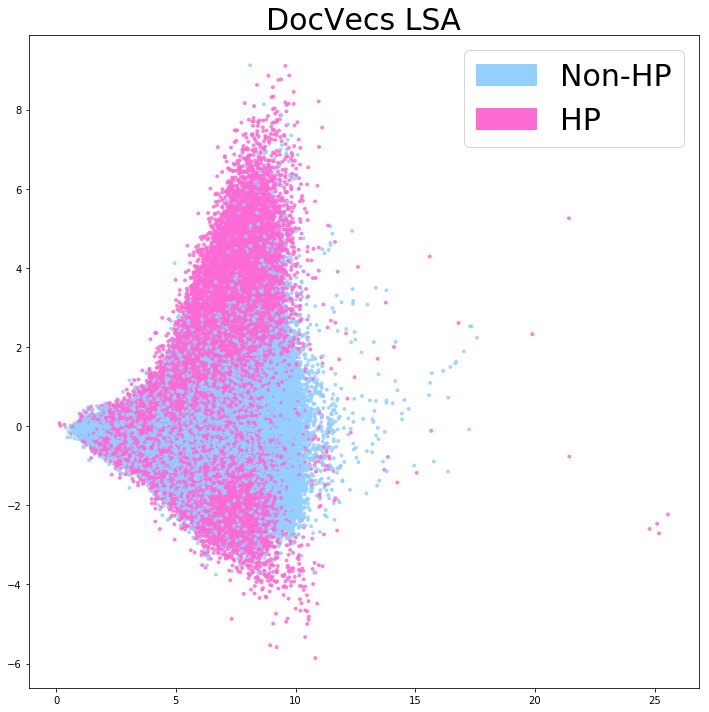

In [21]:
_ = plot_LSA(X_train_docvecs, y_train, title='DocVecs LSA', save_path='../plots/tfidf-docvecs')

In [65]:
lsa_scores = pd.DataFrame(_)

In [78]:
bottom_HP_cloud = train.iloc[lsa_scores[(lsa_scores[0]>5) &
                             ((lsa_scores[1]<0))].index]

In [123]:
bottom_HP_cloud[bottom_HP_cloud['domain']=='foxbusiness'].index

Int64Index([    16,     32,     41,     46,     49,     63,     65,     73,
                82,     83,
            ...
            580870, 580871, 580872, 580888, 580898, 580902, 580903, 580917,
            580920, 580928],
           dtype='int64', length=66001)

In [195]:
train_wo_fb = train[~(train['domain']=='foxbusiness')]

In [196]:
y_train_wo_fb = train_wo_fb['hyperpartisan'].tolist()

In [197]:
train_wo_fb_docvecs = X_train_docvecs[train_wo_fb.index]

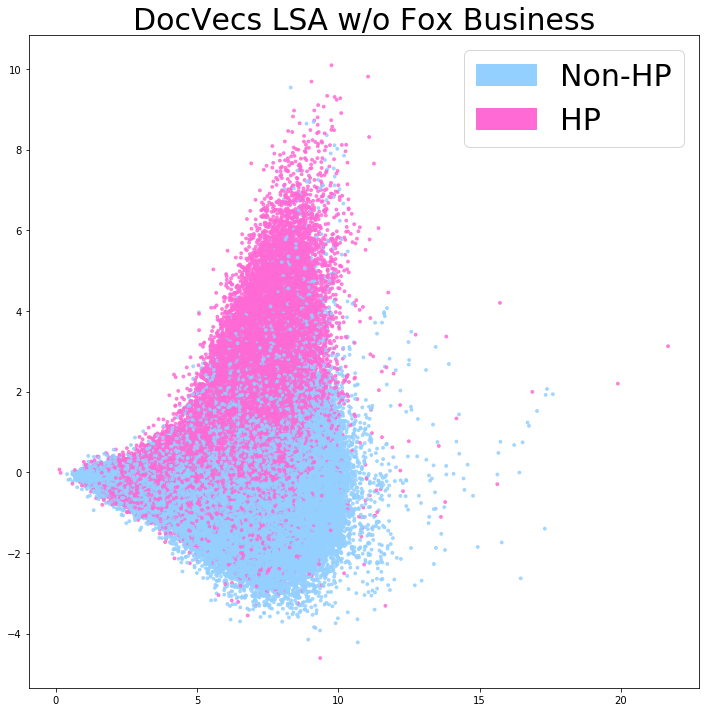

In [198]:
lsa_no_fb = plot_LSA(train_wo_fb_docvecs, y_train_wo_fb, title='DocVecs LSA w/o Fox Business', save_path='../plots/lsa-docvecs-nofb')

In [199]:
lsa_scores = pd.DataFrame(lsa_no_fb)

In [216]:
lsa_scores_with_bias = pd.concat([lsa_scores, train_wo_fb[['hyperpartisan', 'bias']].reset_index()], axis=1)

In [128]:
lr = LogisticRegression(C=0.01, solver='sag', n_jobs=-1, random_state=1)
lr.fit(train_wo_fb_docvecs, y_train_wo_fb)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=1, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [129]:
predictions = lr.predict(X_test_docvecs)
evaluate_model(y_test, predictions)

              precision    recall  f1-score   support

       False       0.62      0.42      0.50     75000
        True       0.56      0.74      0.64     75000

   micro avg       0.58      0.58      0.58    150000
   macro avg       0.59      0.58      0.57    150000
weighted avg       0.59      0.58      0.57    150000

Accuracy: 0.5783


0.5783066666666666

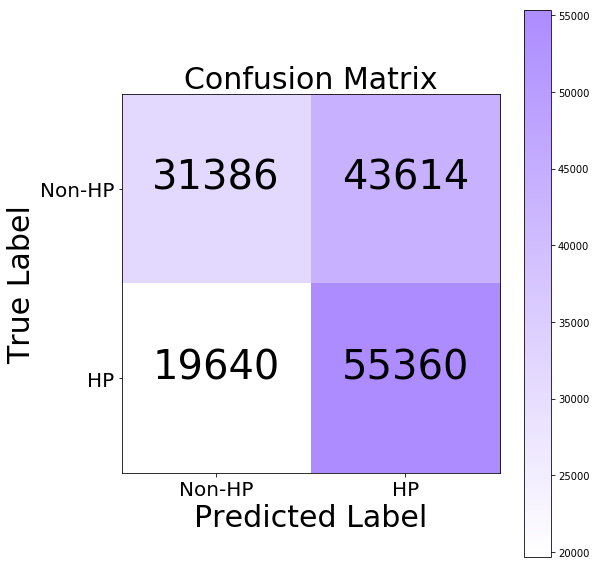

In [137]:
plot_confusion_matrix(y_test, predictions)

In [243]:
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, n_jobs=-1, random_state=1)

In [ ]:
xgb.fit(train_wo_fb_docvecs, y_train_wo_fb)

In [ ]:
predictions = xgb.predict(X_test_docvecs)
evaluate_model(y_test, predictions)

#### MODELS BELOW

In [60]:
lr = LogisticRegression(C=0.01, class_weight='balanced', solver='sag', n_jobs=-1, random_state=1)
lr.fit(X_train_docvecs, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [61]:
predictions = lr.predict(X_test_docvecs)
evaluate_model(y_test, predictions)

              precision    recall  f1-score   support

       False       0.62      0.40      0.49     75000
        True       0.56      0.76      0.64     75000

   micro avg       0.58      0.58      0.58    150000
   macro avg       0.59      0.58      0.56    150000
weighted avg       0.59      0.58      0.56    150000

Accuracy: 0.5787


0.57872

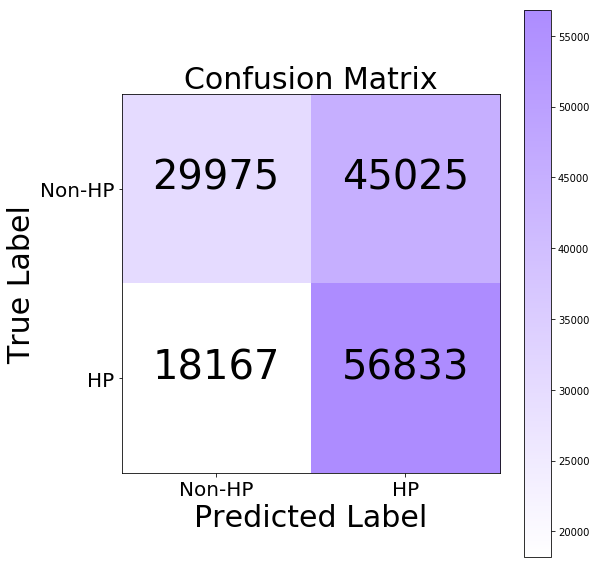

In [62]:
plot_confusion_matrix(y_test, predictions, save_path='../plots/confusion-lr-docvecs')

In [49]:
sgd = SGDClassifier(tol=1e-3, max_iter=1000, penalty='l1', random_state=1)
sgd.fit(X_train_docvecs, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
predictions = sgd.predict(X_test_docvecs)
evaluate_model(y_test, predictions)

              precision    recall  f1-score   support

       False       0.62      0.41      0.49     75000
        True       0.56      0.75      0.64     75000

   micro avg       0.58      0.58      0.58    150000
   macro avg       0.59      0.58      0.57    150000
weighted avg       0.59      0.58      0.57    150000

Accuracy: 0.5782


0.5782266666666667

In [45]:
rf = RandomForestClassifier(n_jobs=-1, verbose=1, n_estimators=100, class_weight='balanced', max_features=15, random_state=1)
rf.fit(X_train_docvecs, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=15,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=1, warm_start=False)

In [46]:
predictions = rf.predict(X_test_docvecs)
evaluate_model(y_test, predictions)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


              precision    recall  f1-score   support

       False       0.60      0.40      0.48     75000
        True       0.55      0.73      0.63     75000

   micro avg       0.57      0.57      0.57    150000
   macro avg       0.57      0.57      0.55    150000
weighted avg       0.57      0.57      0.55    150000

Accuracy: 0.5661


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


0.5661266666666667

#### Document Vectors NN

In [54]:
np.random.seed(1)
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [early_stop]
model_d2v_09_es = Sequential()
model_d2v_09_es.add(Dense(256, activation='relu', input_dim=300))
model_d2v_09_es.add(Dropout(0.3))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dropout(0.3))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dropout(0.3))
model_d2v_09_es.add(Dense(1, activation='sigmoid'))
model_d2v_09_es.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_09_es.fit(X_train_docvecs, y_train,
                    validation_data=(X_test_docvecs, y_test), 
                    epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)

Train on 580929 samples, validate on 150000 samples
Epoch 1/100
 - 48s - loss: 0.4222 - acc: 0.7963 - val_loss: 1.1310 - val_acc: 0.5720
Epoch 2/100
 - 46s - loss: 0.3990 - acc: 0.8113 - val_loss: 1.1609 - val_acc: 0.5676
Epoch 3/100
 - 47s - loss: 0.3914 - acc: 0.8160 - val_loss: 1.0849 - val_acc: 0.5773
Epoch 4/100
 - 46s - loss: 0.3864 - acc: 0.8186 - val_loss: 1.1108 - val_acc: 0.5659
Epoch 5/100
 - 47s - loss: 0.3827 - acc: 0.8214 - val_loss: 1.1984 - val_acc: 0.5655
Epoch 6/100
 - 46s - loss: 0.3801 - acc: 0.8225 - val_loss: 1.2903 - val_acc: 0.5621
Epoch 7/100
 - 47s - loss: 0.3774 - acc: 0.8240 - val_loss: 1.1592 - val_acc: 0.5741
Epoch 8/100
 - 46s - loss: 0.3750 - acc: 0.8250 - val_loss: 1.1554 - val_acc: 0.5703


## Problem Challenges

#### Topic Imbalance

#### Noisy Class Labels

In [123]:
t = train[(train['preprocessed_text'].str.contains('movie')) &
         (train['hyperpartisan']==True)].reset_index()[['url', 'article_text']]

In [127]:
t.iloc[47]['url']

'https://thedailybeast.com/joan-juliet-buck-on-being-in-awe-of-nora-ephron'

In [93]:
np.random.seed(1)
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [early_stop]
model_d2v_09_es = Sequential()
model_d2v_09_es.add(Dense(256, activation='relu', input_dim=300))
model_d2v_09_es.add(Dropout(0.3))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dropout(0.3))
model_d2v_09_es.add(Dense(256, activation='relu'))
model_d2v_09_es.add(Dropout(0.3))
model_d2v_09_es.add(Dense(1, activation='sigmoid'))
model_d2v_09_es.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_09_es.fit(train_wo_fb_docvecs, y_train_wo_fb,
                    validation_data=(X_test_docvecs, y_test), 
                    epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)

Train on 484923 samples, validate on 150000 samples
Epoch 1/100
 - 42s - loss: 0.3728 - acc: 0.8317 - val_loss: 0.9556 - val_acc: 0.5708
Epoch 2/100
 - 44s - loss: 0.3491 - acc: 0.8447 - val_loss: 1.0397 - val_acc: 0.5728
Epoch 3/100
 - 42s - loss: 0.3418 - acc: 0.8486 - val_loss: 1.0465 - val_acc: 0.5715
Epoch 4/100
 - 42s - loss: 0.3368 - acc: 0.8507 - val_loss: 1.0384 - val_acc: 0.5755
Epoch 5/100
 - 41s - loss: 0.3327 - acc: 0.8527 - val_loss: 1.0787 - val_acc: 0.5705
Epoch 6/100
 - 41s - loss: 0.3298 - acc: 0.8546 - val_loss: 1.1124 - val_acc: 0.5808
Epoch 7/100
 - 44s - loss: 0.3264 - acc: 0.8559 - val_loss: 1.0702 - val_acc: 0.5774
Epoch 8/100
 - 43s - loss: 0.3249 - acc: 0.8569 - val_loss: 1.1297 - val_acc: 0.5749
Epoch 9/100
 - 42s - loss: 0.3230 - acc: 0.8580 - val_loss: 1.0810 - val_acc: 0.5683
Epoch 10/100
 - 43s - loss: 0.3211 - acc: 0.8588 - val_loss: 1.1760 - val_acc: 0.5748
Epoch 11/100
 - 43s - loss: 0.3192 - acc: 0.8597 - val_loss: 1.3465 - val_acc: 0.5794
